# Generacion de datos sinteticos para el modelo

## Fase 1: Configuraci√≥n y Par√°metros del Entorno üõ†Ô∏è

Esta secci√≥n ser√° la "consola de control" de tu simulaci√≥n. Definiremos todas las variables aqu√≠ para que sea f√°cil experimentar.

    Par√°metros F√≠sicos del Robot:

        DISTANCIA_ENTRE_SENSORES: La separaci√≥n f√≠sica entre los sensores (ej. 15 cm).

        DISTANCIA_DE_ENFOQUE: Tu distancia de enfoque √≥ptima (150 cm).

    Par√°metros de Barrido:

        RANGO_DE_ANGULO: El campo de visi√≥n total (140 grados).

        NUMERO_DE_PASOS: Cu√°ntas "fotograf√≠as" tomar√° el sonar para cubrir el rango. Esto definir√° el PASO_ANGULAR.

        ANGULOS_DE_BARRIDO: La lista de √°ngulos discretos que el sensor central usar√° (ej. [70, 46.6, ...]).

    Par√°metros del Sensor:

        SINGLE_BEAM_SHAPE_POINTS: La lista de coordenadas que definen la forma del l√≥bulo realista que mediste.

    Par√°metros de la Simulaci√≥n:

        NUM_MUESTRAS_POR_PASO: Cu√°ntos objetos aleatorios generar para cada uno de los √°ngulos de barrido.

        TIPOS_DE_OBJETO: Una lista de geometr√≠as a simular (ej. ['circulo', 'rectangulo']).

        RANGO_DE_TAMA√ëO_OBJETO: Los tama√±os m√≠nimos y m√°ximos de los objetos.

    Par√°metros del Espacio de Salida (para el ML):

        TAMA√ëO_DEL_CUADRANTE: El grano de tu rejilla de detecci√≥n (6 cm).

## Fase 2: Funciones de Modelado Geom√©trico üìê

Aqu√≠ pondremos las funciones reutilizables que se encargan de la geometr√≠a, basadas en lo que ya hemos desarrollado.

    obtener_angulos_optimos(theta_central): La funci√≥n que ya tenemos, que calcula los √°ngulos de los sensores laterales.

    crear_haz_desde_puntos(...): La funci√≥n que toma los puntos del l√≥bulo y crea el pol√≠gono shapely base.

    generar_area_de_barrido(angulo_central): Una nueva funci√≥n clave que:

        Toma el √°ngulo del sensor central.

        Calcula los √°ngulos √≥ptimos de los laterales.

        Crea las tres geometr√≠as de los haces (l√≥bulos).

        Las rota y traslada a sus posiciones correctas.

        Devuelve la uni√≥n de los tres haces, que es el √°rea total de detecci√≥n para ese paso de barrido.

In [76]:
# Importar las librer√≠as necesarias para esta fase
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros del Entorno
# ===================================================================
# En esta secci√≥n defines el comportamiento de toda la simulaci√≥n.

# --- Par√°metros F√≠sicos del Robot ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIA_DE_ENFOQUE = 150 # cm (Tu distancia de enfoque √≥ptima)

# --- Par√°metros de Barrido ---
RANGO_DE_ANGULO = 140.0  # Grados (Campo de visi√≥n total)
NUMERO_DE_PASOS = 9      # Cantidad de "fotograf√≠as" del sonar
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1) # Calculamos el paso para incluir los extremos
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)

# --- Par√°metros del Sensor (L√≥bulo Realista) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# Factor para convertir las unidades de los puntos del l√≥bulo a cm
FACTOR_ESCALA_HAZ = 100.0


# ===================================================================
# FASE 2: Funciones de Modelado Geom√©trico
# ===================================================================
# Estas funciones se encargan de toda la geometr√≠a del sistema.

def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los √°ngulos √≥ptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    # Sensor Izquierdo
    angulo_math_izq = np.arctan2(py, px + d)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    # Sensor Derecho
    angulo_math_der = np.arctan2(py, px - d)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    """Crea el pol√≠gono Shapely base para un solo sensor."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_area_de_barrido(angulo_central):
    """
    Genera el √°rea de detecci√≥n combinada (uni√≥n de los 3 haces) para un
    √°ngulo de barrido espec√≠fico del sensor central.
    """
    # Obtener los √°ngulos coordinados
    angulo_izq, angulo_der = obtener_angulos_optimos(
        angulo_central,
        DISTANCIA_ENTRE_SENSORES,
        DISTANCIA_DE_ENFOQUE
    )
    
    # Crear el pol√≠gono base del l√≥bulo
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    
    # --- Orientar y posicionar cada haz ---
    # Haz central: rotado al √°ngulo de barrido
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    
    # Haz izquierdo: rotado a su √°ngulo √≥ptimo y trasladado a su posici√≥n
    haz_izq_rotado = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq_rotado, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    # Haz derecho: rotado a su √°ngulo √≥ptimo y trasladado
    haz_der_rotado = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der_rotado, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # El √°rea de barrido es la uni√≥n de las tres geometr√≠as
    area_total = haz_central.union(haz_izq).union(haz_der)
    
    return area_total

√Ångulos de barrido calculados (grados):
[-70.  -52.5 -35.  -17.5   0.   17.5  35.   52.5  70. ]


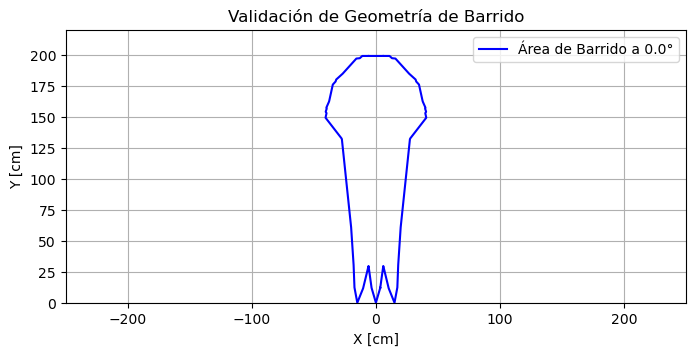

In [77]:
# ===================================================================
# Bloque de Validaci√≥n y Visualizaci√≥n (para probar en el notebook)
# ===================================================================

print("√Ångulos de barrido calculados (grados):")
print(np.round(ANGULOS_DE_BARRIDO, 2))

# Elige un √°ngulo de la lista para visualizar (ej. el segundo paso: 46.7¬∞)
angulo_de_prueba = ANGULOS_DE_BARRIDO[4] 

# Genera el √°rea de detecci√≥n para ese √°ngulo
area_de_prueba = generar_area_de_barrido(angulo_de_prueba)

# Dibuja el resultado
fig, ax = plt.subplots(figsize=(8, 8))
if area_de_prueba.geom_type == 'Polygon':
    ax.plot(*area_de_prueba.exterior.xy, color='blue', label=f'√Årea de Barrido a {angulo_de_prueba:.1f}¬∞')
elif area_de_prueba.geom_type == 'MultiPolygon':
    for poly in area_de_prueba.geoms:
        ax.plot(*poly.exterior.xy, color='blue')
    ax.scatter([],[], color='blue', label=f'√Årea de Barrido a {angulo_de_prueba:.1f}¬∞') # Para la leyenda


ax.set_title("Validaci√≥n de Geometr√≠a de Barrido")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

## Fase 3: Simulaci√≥n de la Reflexi√≥n del Eco (Ray-Tracing Simplificado) üåä

Esta es la parte m√°s novedosa. Crearemos una funci√≥n que imite c√≥mo los sensores recibir√≠an un eco de un objeto simulado.

    simular_reflexiones(objeto, angulo_central):

        Entrada: Un objeto (un pol√≠gono shapely) y el angulo_central del barrido.

        Proceso:

            Genera las geometr√≠as de los tres haces para ese √°ngulo (haz_izq, haz_cen, haz_der).

            Para cada uno de los 3 sensores:

                Comprueba si su haz individual se interseca con el objeto.

                Si hay intersecci√≥n, significa que ese sensor "ve" el objeto.

                Calcula la distancia desde el origen del sensor hasta el punto m√°s cercano del objeto. Este ser√° nuestro tiempo de vuelo simulado.

                Si no hay intersecci√≥n, la distancia para ese sensor es infinita (o un valor muy grande).

        Salida: Devuelve una lista con los 3 tiempos de eco simulados.

In [78]:
# Importar las librer√≠as necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
import random

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros (sin cambios)
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 8
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# ===================================================================
# FASE 2: Funciones de Modelado Geom√©trico (sin cambios)
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

# ===================================================================
# FASE 3: Simulaci√≥n de la Reflexi√≥n del Eco
# ===================================================================
# Esta nueva funci√≥n simula los tiempos de eco para un objeto dado.

def simular_reflexiones(objeto, angulo_central):
    """
    Simula las distancias de eco de los 3 sensores a un objeto, para un
    √°ngulo de barrido espec√≠fico.
    """
    # Or√≠genes de los sensores
    origen_s1 = Point(-DISTANCIA_ENTRE_SENSORES, 0)
    origen_s2 = Point(0, 0)
    origen_s3 = Point(DISTANCIA_ENTRE_SENSORES, 0)
    
    # Calcular los √°ngulos √≥ptimos para el barrido
    angulo_izq, angulo_der = obtener_angulos_optimos(
        angulo_central,
        DISTANCIA_ENTRE_SENSORES,
        DISTANCIA_DE_ENFOQUE
    )
    
    # Crear la geometr√≠a base del haz
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    
    # Generar las geometr√≠as de los tres haces en sus posiciones y orientaciones
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = affinity.translate(affinity.rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = affinity.translate(affinity.rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    
    haces = [haz_izq, haz_central, haz_der]
    origenes = [origen_s1, origen_s2, origen_s3]
    distancias_eco = []
    
    # Para cada sensor, comprobar si "ve" el objeto
    for haz, origen in zip(haces, origenes):
        # La condici√≥n es que el objeto se superponga con el haz del sensor
        if objeto.intersects(haz):
            # La distancia del eco es la distancia desde el sensor al punto m√°s cercano del objeto
            distancia = origen.distance(objeto)
            distancias_eco.append(distancia)
        else:
            # Si no hay intersecci√≥n, el sensor no recibe eco de este objeto.
            # Usamos un valor muy grande para representar "sin eco".
            distancias_eco.append(np.inf)
            
    return distancias_eco, haces # Devolvemos los haces para poder visualizarlos

Resultados para un objeto en (-60.0, 120.0) con barrido a 23.3¬∞:
--------------------------------------------------
Distancia simulada Sensor 1 (izq): 123.16 cm
Distancia simulada Sensor 2 (cen): 129.17 cm
Distancia simulada Sensor 3 (der): 136.51 cm
--------------------------------------------------


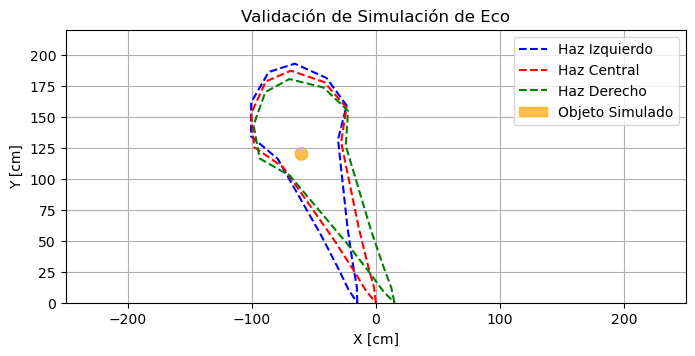

In [79]:
# ===================================================================
# Bloque de Validaci√≥n y Visualizaci√≥n (para probar la Fase 3)
# ===================================================================

# 1. Elige un √°ngulo de barrido para la prueba
angulo_de_prueba = 23.3  # Puedes cambiar este valor

# 2. Crea un objeto de prueba (un c√≠rculo de 5 cm de radio) en una posici√≥n
#    que deber√≠a ser visible en ese √°ngulo de barrido.
objeto_de_prueba = Point(-60, 120).buffer(5)

# 3. Llama a la funci√≥n de simulaci√≥n
distancias, haces_de_prueba = simular_reflexiones(objeto_de_prueba, angulo_de_prueba)

print(f"Resultados para un objeto en ({objeto_de_prueba.centroid.x:.1f}, {objeto_de_prueba.centroid.y:.1f}) "
      f"con barrido a {angulo_de_prueba}¬∞:")
print("-" * 50)
print(f"Distancia simulada Sensor 1 (izq): {distancias[0]:.2f} cm")
print(f"Distancia simulada Sensor 2 (cen): {distancias[1]:.2f} cm")
print(f"Distancia simulada Sensor 3 (der): {distancias[2]:.2f} cm")
print("-" * 50)


# 4. Visualiza el resultado para confirmaci√≥n
fig, ax = plt.subplots(figsize=(8, 8))

# Dibuja los tres haces
colores = ['blue', 'red', 'green']
nombres = ['Haz Izquierdo', 'Haz Central', 'Haz Derecho']
for haz, color, nombre in zip(haces_de_prueba, colores, nombres):
    ax.plot(*haz.exterior.xy, color=color, linestyle='--', label=nombre)

# Dibuja el objeto de prueba
ax.fill(*objeto_de_prueba.exterior.xy, color='orange', alpha=0.7, label='Objeto Simulado')

ax.set_title("Validaci√≥n de Simulaci√≥n de Eco")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

## Fase 4: Generaci√≥n del Dataset (Bucle Principal) üîÑ

Este es el coraz√≥n del script, donde todo se une.

    Inicializar: Crea una rejilla de cuadrantes global que cubra todo el semic√≠rculo de 180 grados y dos listas vac√≠as: features y labels.

    Bucle Externo (por √Ångulo): Itera sobre cada angulo_central en tu lista ANGULOS_DE_BARRIDO.

        Calcula el area_de_barrido para ese √°ngulo.

    Bucle Interno (por Muestra): Itera NUM_MUESTRAS_POR_PASO veces.

        Generar Objeto Aleatorio:

            Elige un tipo y tama√±o de objeto al azar.

            Crea el pol√≠gono del objeto en una posici√≥n aleatoria dentro del area_de_barrido.

        Calcular la Etiqueta (Y): Determina con qu√© cuadrantes de la rejilla global se superpone el objeto. Esto genera el vector de salida (la "label").

        Calcular las Caracter√≠sticas (X):

            Llama a simular_reflexiones para obtener los 3 tiempos de eco.

            ¬°Crucial! Pasa estos 3 tiempos a una versi√≥n simplificada de tu funci√≥n output_dimention_pulses de helpers.py. Esto convertir√° los tiempos de eco en la "firma de eco" de 243 valores, asegurando que tus datos simulados tengan el mismo formato que tus datos reales.

            Concatena el angulo_central con la firma de eco de 243 valores para crear el vector de caracter√≠sticas final (244 valores).

        Guardar: A√±ade el vector de caracter√≠sticas a features y el vector de etiquetas a labels.



In [80]:
# Importar las librer√≠as necesarias para estas fases
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm.notebook import tqdm # Para una barra de progreso visual

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros (sin cambios)
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# --- Par√°metros de la Simulaci√≥n ---
NUM_MUESTRAS_POR_PASO = 250  # Generaremos 250 objetos por cada √°ngulo de barrido
TIPOS_DE_OBJETO = ['circulo', 'rectangulo']
RANGO_DE_TAMA√ëO_OBJETO = [5.0, 15.0] # en cm (radio para c√≠rculos, lado para cuadrados)
TAMA√ëO_DEL_CUADRANTE = 6.0 # en cm
VELOCIDAD_SONIDO = 34300 # cm/s
FRECUENCIA_MUESTREO_ADC = 140000 # Hz (simula la captura cruda)
FRECUENCIA_MUESTREO_ML = 6800   # Hz (la frecuencia del espacio de caracter√≠sticas)


# ===================================================================
# FASE 2 y 3: Funciones Geom√©tricas y de Simulaci√≥n de Eco (sin cambios)
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)
    
def generar_area_de_barrido(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return haz_central.union(haz_izq).union(haz_der), [haz_izq, haz_central, haz_der]

def simular_reflexiones(objeto, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    distancias_eco = []
    for haz, origen in zip(haces_individuales, origenes):
        if objeto.intersects(haz):
            distancia = origen.distance(objeto)
            distancias_eco.append(distancia)
        else:
            distancias_eco.append(np.inf)
    return distancias_eco

# ===================================================================
# FASE 4: Generaci√≥n del Dataset (Bucle Principal)
# ===================================================================

def distancias_a_firma_eco(distancias_cm):
    """
    Convierte las 3 distancias de eco simuladas a la "firma de eco" de 243 valores
    que espera el modelo de ML.
    """
    firma_eco_total = []
    ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    
    for dist_cm in distancias_cm:
        firma_sensor = np.zeros(81)
        if dist_cm != np.inf:
            # Calcular tiempo de ida y vuelta
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            # Convertir tiempo a √≠ndice de muestra del ADC
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            # Simular la transformaci√≥n de `output_dimention_pulses`
            # Esta es una aproximaci√≥n, asumiendo que el eco se mapea a un √≠ndice
            indice_ml = int((indice_adc - 100) * ratio_conversion) # Restamos 100 por el offset
            
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
        
    return np.array(firma_eco_total)


def generar_objeto_aleatorio(area_madre):
    """Genera un objeto (c√≠rculo o rect√°ngulo) en una posici√≥n aleatoria dentro del √°rea dada."""
    min_x, min_y, max_x, max_y = area_madre.bounds
    tipo = random.choice(TIPOS_DE_OBJETO)
    tama√±o = random.uniform(*RANGO_DE_TAMA√ëO_OBJETO)
    
    # Intenta generar un objeto que est√© completamente dentro del √°rea
    for _ in range(50): # Limita los intentos para evitar bucles infinitos
        px = random.uniform(min_x, max_x)
        py = random.uniform(min_y, max_y)
        
        if tipo == 'circulo':
            objeto = Point(px, py).buffer(tama√±o)
        else: # rectangulo
            objeto = box(px, py, px + tama√±o, py + tama√±o)
            
        if area_madre.contains(objeto):
            return objeto
            
    return None # No se pudo generar un objeto v√°lido

# --- Bucle Principal de Generaci√≥n ---
features_list = []
labels_list = []

# 1. Crear la rejilla de cuadrantes global
area_total_visible = box(-250, 0, 250, 220)
x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMA√ëO_DEL_CUADRANTE)
y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMA√ëO_DEL_CUADRANTE)
cuadrantes_globales = [box(x, y, x + TAMA√ëO_DEL_CUADRANTE, y + TAMA√ëO_DEL_CUADRANTE) for x in x_coords for y in y_coords]
num_cuadrantes = len(cuadrantes_globales)


print(f"Generando dataset con {NUMERO_DE_PASOS} pasos angulares...")
# Bucle Externo: Itera sobre cada √°ngulo de barrido
for angulo_central in tqdm(ANGULOS_DE_BARRIDO, desc="Progreso del Barrido"):
    
    # Genera el √°rea de detecci√≥n y los haces individuales para este √°ngulo
    area_de_barrido, haces_individuales = generar_area_de_barrido(angulo_central)
    
    # Bucle Interno: Genera N muestras por cada √°ngulo
    for _ in range(NUM_MUESTRAS_POR_PASO):
        
        # Genera un objeto aleatorio dentro del √°rea de este barrido
        objeto = generar_objeto_aleatorio(area_de_barrido)
        if objeto is None: continue # Si no se pudo generar, saltar

        # --- Calcular la Etiqueta (Y) ---
        label = np.zeros(num_cuadrantes)
        for i, cuadrante in enumerate(cuadrantes_globales):
            if objeto.intersects(cuadrante):
                label[i] = 1
        
        # --- Calcular las Caracter√≠sticas (X) ---
        distancias_eco = simular_reflexiones(objeto, haces_individuales)
        firma_eco_ml = distancias_a_firma_eco(distancias_eco)
        
        # Feature final: [angulo, eco_s1..., eco_s2..., eco_s3...]
        feature = np.concatenate(([angulo_central], firma_eco_ml))
        
        # Guardar en las listas
        features_list.append(feature)
        labels_list.append(label)

print("\nGeneraci√≥n del dataset completada.")
print(f"Total de muestras generadas: {len(features_list)}")

# ===================================================================
# FASE 5: Guardado de Archivos
# ===================================================================

# Convertir a DataFrames y guardar
df_features = pd.DataFrame(features_list)
df_labels = pd.DataFrame(labels_list)

df_features.to_csv("features_simuladas.csv", index=False)
df_labels.to_csv("labels_simuladas.csv", index=False)

print("\nArchivos 'features_simuladas.csv' y 'labels_simuladas.csv' guardados.")

Generando dataset con 9 pasos angulares...


Progreso del Barrido:   0%|          | 0/9 [00:00<?, ?it/s]


Generaci√≥n del dataset completada.
Total de muestras generadas: 2250

Archivos 'features_simuladas.csv' y 'labels_simuladas.csv' guardados.


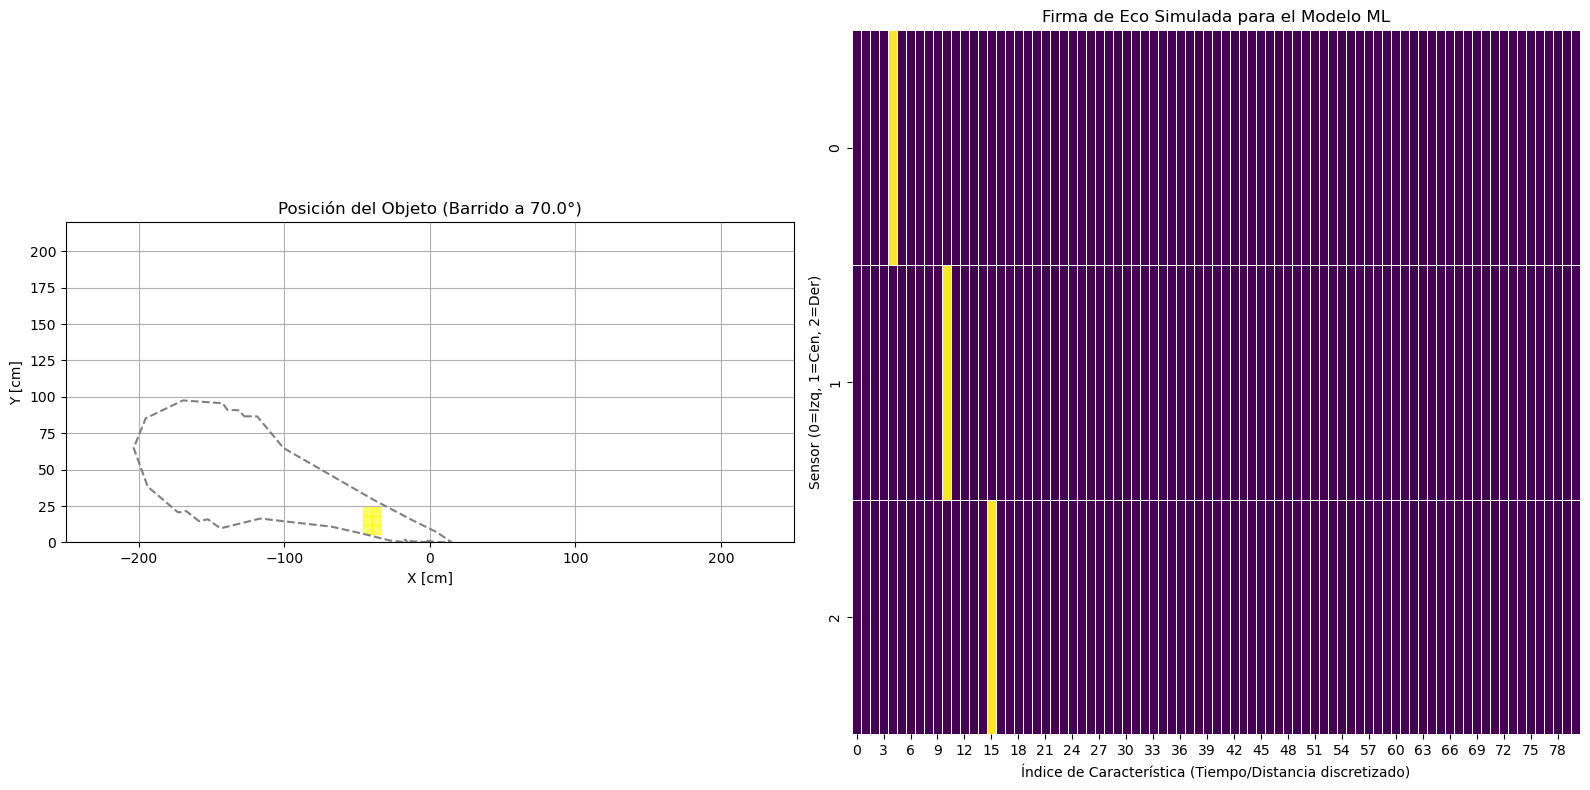

In [83]:
# ===================================================================
# Bloque de Validaci√≥n y Visualizaci√≥n (para probar una muestra)
# ===================================================================
import seaborn as sns # Necesario para el heatmap
# Tomar la √∫ltima muestra generada para visualizar
ultima_feature = features_list[-15]
ultima_label = labels_list[-15]

# Extraer la informaci√≥n de la muestra
angulo_muestra = ultima_feature[0]
firma_eco_muestra = ultima_feature[1:] # Los 243 valores del eco
area_muestra, _ = generar_area_de_barrido(angulo_muestra)
cuadrantes_activos_indices = np.where(ultima_label == 1)[0]

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Gr√°fico 1: Vista Espacial (como antes) ---
if area_muestra.geom_type == 'Polygon': ax1.plot(*area_muestra.exterior.xy, color='gray', linestyle='--')
elif area_muestra.geom_type == 'MultiPolygon':
    for poly in area_muestra.geoms: ax1.plot(*poly.exterior.xy, color='gray', linestyle='--')

for idx in cuadrantes_activos_indices:
    cuadrante = cuadrantes_globales[idx]
    ax1.fill(*cuadrante.exterior.xy, color='yellow', alpha=0.6)

ax1.set_title(f"Posici√≥n del Objeto (Barrido a {angulo_muestra:.1f}¬∞)")
ax1.set_xlabel("X [cm]"); ax1.set_ylabel("Y [cm]")
ax1.set_xlim(-250, 250); ax1.set_ylim(0, 220)
ax1.set_aspect('equal', adjustable='box'); ax1.grid(True)

# --- Gr√°fico 2: Firma de Eco Simulada ---
# Reorganizar el vector de 243 a una matriz de 3x81
firma_eco_matriz = firma_eco_muestra.reshape(3, 81)

sns.heatmap(firma_eco_matriz, ax=ax2, cbar=False, cmap="viridis", linewidths=.5)
ax2.set_title("Firma de Eco Simulada para el Modelo ML")
ax2.set_xlabel("√çndice de Caracter√≠stica (Tiempo/Distancia discretizado)")
ax2.set_ylabel("Sensor (0=Izq, 1=Cen, 2=Der)")

plt.tight_layout() # Ajusta el espaciado entre gr√°ficos
plt.show()

### Dataset multiobjeto y raytracing con oclusion

En esta seccion mejoraremos la simulacion, agregando multiples objetos al sistema convirtiendo el problema de clasificacion a multi etiqueta. ademas incluiremos el concepto de oclusion, por lo que la simulacion tendra en cuenta la sombra que generan los objetos mas cercanos respecto a los lejanos.

#### Fase 3: Generaci√≥n de Escenas Complejas.

El objetivo aqu√≠ es crear una funci√≥n que, en lugar de generar un solo objeto, construya una "escena" completa y aleatoria en cada iteraci√≥n. Esta escena contendr√° un n√∫mero variable de objetos de diferentes tipos (c√≠rculos, rect√°ngulos y "paredes") y tama√±os, distribuidos de forma aleatoria dentro del campo de visi√≥n total del sonar.

In [84]:
# Importar las librer√≠as necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.affinity import rotate, translate
import random

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros (Expandida)
# ===================================================================
# --- Par√°metros F√≠sicos y de Barrido (sin cambios) ---
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 8
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# --- Par√°metros de la Escena (NUEVO) ---
MAX_OBJETOS_POR_ESCENA = 10
# Probabilidades para cada tipo de objeto
PROPORCIONES_OBJETOS = {
    'circulo': 0,
    'rectangulo': 1,
    'pared': 0
}
# Rango de tama√±os [min, max] en cm
RANGO_TAMA√ëO_CIRCULO = [5.0, 12.0]  # Radios
RANGO_TAMA√ëO_RECTANGULO = [8.0, 20.0] # Lados de cuadrados
RANGO_TAMA√ëO_PARED = [50.0, 100.0] # Longitud de la pared

# ===================================================================
# FASE 2: Funciones de Modelado Geom√©trico (sin cambios)
# ===================================================================
# ... (Aqu√≠ ir√≠an las funciones obtener_angulos_optimos, crear_haz_desde_puntos,
#      y generar_area_de_barrido que ya tenemos, las omito por brevedad pero
#      deben estar en el notebook para que esta celda funcione)
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_area_de_barrido(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return haz_central.union(haz_izq).union(haz_der)
# ===================================================================
# FASE 3: Generaci√≥n de Escenas Complejas
# ===================================================================

def generar_escena_aleatoria(area_total_visible):
    """
    Genera una escena con un n√∫mero aleatorio de objetos de diferentes tipos y tama√±os
    dentro del √°rea de visi√≥n total del sonar.
    """
    escena = []
    num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    min_x, min_y, max_x, max_y = area_total_visible.bounds
    
    tipos = list(PROPORCIONES_OBJETOS.keys())
    probabilidades = list(PROPORCIONES_OBJETOS.values())

    for _ in range(num_objetos):
        # Elige un tipo de objeto basado en las probabilidades
        tipo_objeto = np.random.choice(tipos, p=probabilidades)
        
        # Posici√≥n aleatoria
        px = random.uniform(min_x, max_x)
        py = random.uniform(min_y, max_y)
        
        objeto = None
        if tipo_objeto == 'circulo':
            radio = random.uniform(*RANGO_TAMA√ëO_CIRCULO)
            objeto = Point(px, py).buffer(radio)
        
        elif tipo_objeto == 'rectangulo':
            lado = random.uniform(*RANGO_TAMA√ëO_RECTANGULO)
            # Generamos un cuadrado
            objeto = box(px - lado/2, py - lado/2, px + lado/2, py + lado/2)
            # Rotaci√≥n aleatoria para m√°s variedad
            objeto = rotate(objeto, random.uniform(0, 360), origin='centroid')

        elif tipo_objeto == 'pared':
            longitud = random.uniform(*RANGO_TAMA√ëO_PARED)
            # Generar como una l√≠nea gruesa (un rect√°ngulo delgado)
            p1 = (px - longitud/2, py)
            p2 = (px + longitud/2, py)
            objeto = LineString([p1, p2]).buffer(2) # 2 cm de grosor
            # Rotaci√≥n aleatoria
            objeto = rotate(objeto, random.uniform(0, 360), origin='centroid')

        # Comprobaci√≥n de colisiones simples: si el nuevo objeto no se superpone
        # demasiado con los existentes, lo a√±adimos.
        colision = False
        if objeto:
            for obj_existente in escena:
                # Si el nuevo objeto est√° casi completamente dentro de uno existente, no lo a√±adimos.
                if obj_existente.contains(objeto.centroid):
                    colision = True
                    break
            if not colision:
                escena.append(objeto)
                
    return escena

Escena generada con 8 objetos.


/tmp/ipykernel_7874/1872588405.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('Set2', MAX_OBJETOS_POR_ESCENA)


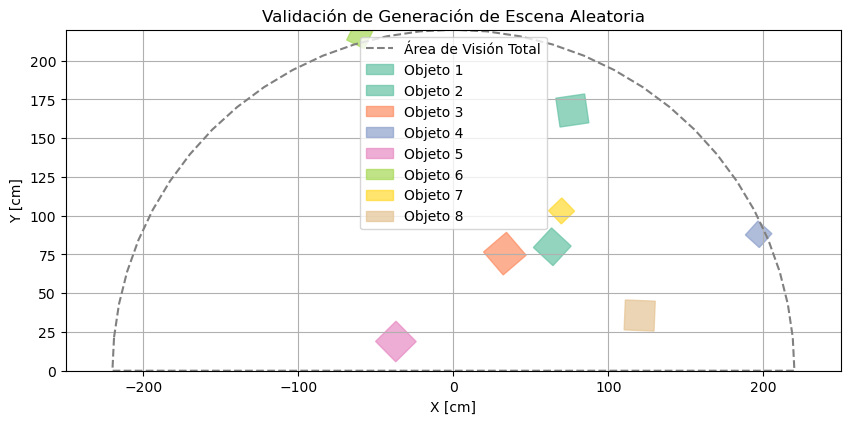

In [85]:
# ===================================================================
# Bloque de Validaci√≥n y Visualizaci√≥n (para probar la Fase 3)
# ===================================================================

# 1. Definir el √°rea total visible para generar los objetos
# Un semic√≠rculo grande es una buena aproximaci√≥n del √°rea total de 180¬∞
area_total_simulacion = Point(0, 0).buffer(220).intersection(box(-250, 0, 250, 220))

# 2. Generar una escena aleatoria de prueba
escena_de_prueba = generar_escena_aleatoria(area_total_simulacion)

print(f"Escena generada con {len(escena_de_prueba)} objetos.")

# 3. Visualizar la escena generada
fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el √°rea total de simulaci√≥n
ax.plot(*area_total_simulacion.exterior.xy, color='gray', linestyle='--', label='√Årea de Visi√≥n Total')

# Dibujar cada objeto en la escena
colores = plt.cm.get_cmap('Set2', MAX_OBJETOS_POR_ESCENA)
for i, objeto in enumerate(escena_de_prueba):
    if objeto.geom_type == 'Polygon':
        ax.fill(*objeto.exterior.xy, color=colores(i), alpha=0.7, label=f'Objeto {i+1}')
    elif objeto.geom_type == 'MultiPolygon': # A veces un buffer puede crear esto
        for poly in objeto.geoms:
            ax.fill(*poly.exterior.xy, color=colores(i), alpha=0.7)
        ax.scatter([], [], color=colores(i), label=f'Objeto {i+1}') # Para la leyenda

# Configuraci√≥n del gr√°fico
ax.set_title("Validaci√≥n de Generaci√≥n de Escena Aleatoria")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

#### Fase 4 y 5: Generaci√≥n del Dataset con Oclusi√≥n y Etiquetas F√≠sicas

Este es el paso m√°s complejo y crucial. Aqu√≠ implementaremos el "ray-tracing con oclusi√≥n", generaremos las etiquetas multi-objeto basadas en la f√≠sica del eco y construiremos el bucle principal que crear√° nuestro dataset final.

[1093 1094 1167 1241 1279 1422]


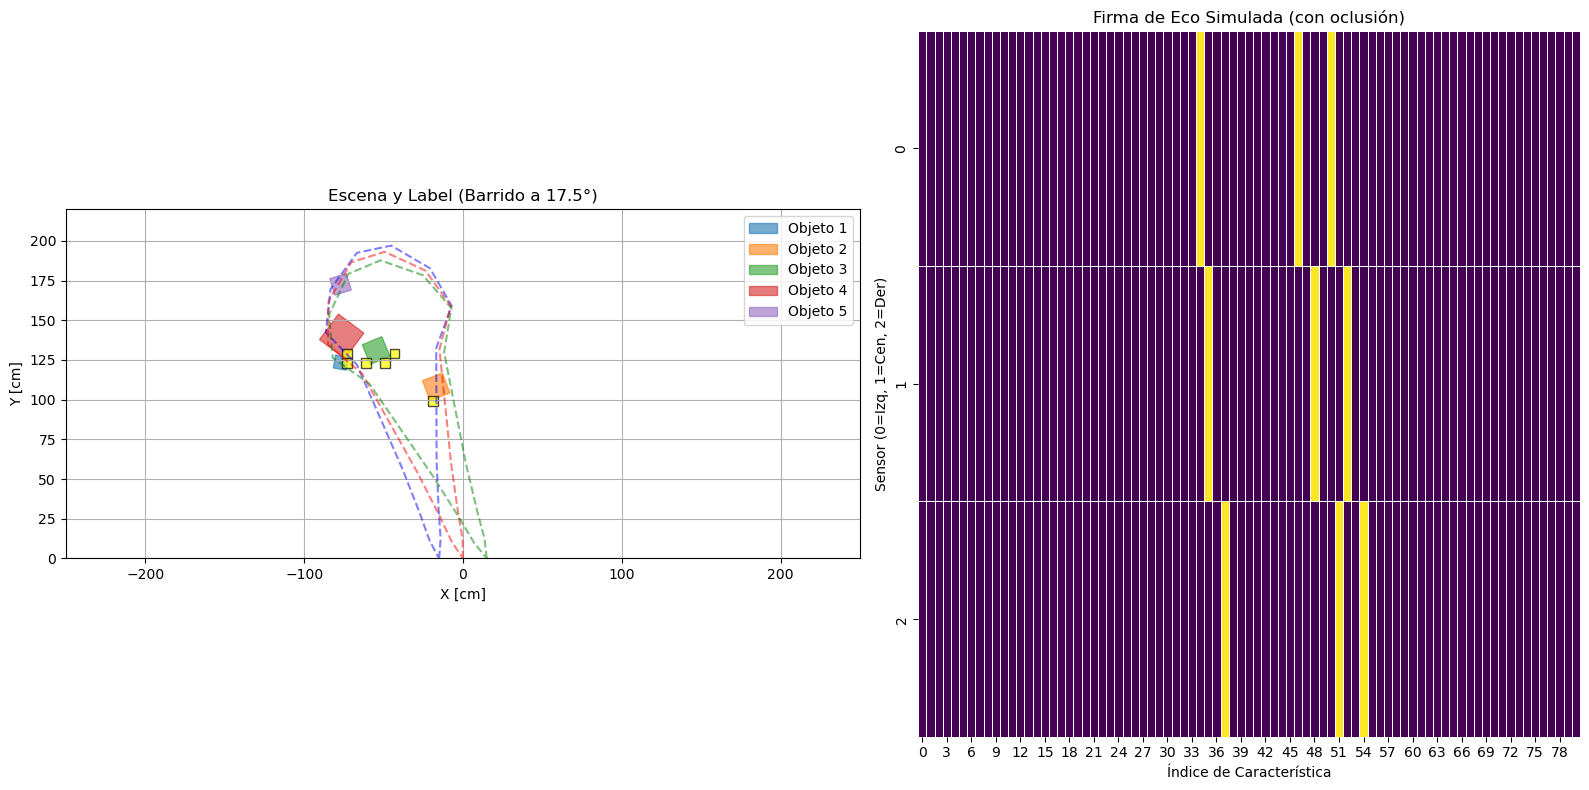

In [132]:
# ===================================================================
# Bloque de Validaci√≥n y Visualizaci√≥n (para una muestra)
# ===================================================================
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1.2, 1]})

sample_number = 9

# Tomar la √∫ltima muestra para validar
escena_muestra = escena_list[sample_number] # La √∫ltima escena generada
angulo_muestra = angulo_central_list[sample_number]
haces_muestra = haces_list[sample_number]
label_muestra = labels_list[sample_number]
firma_eco_muestra = firma_eco_list[sample_number]

# --- Gr√°fico 1: Vista Espacial ---
colores_haces = ['blue', 'red', 'green']
for haz, color in zip(haces_muestra, colores_haces):
    ax1.plot(*haz.exterior.xy, color=color, linestyle='--', alpha=0.5)

for i, obj in enumerate(escena_muestra):
    ax1.fill(*obj.exterior.xy, color=f'C{i}', alpha=0.6, label=f'Objeto {i+1}')

cuadrantes_activos_indices = np.where(label_muestra == 1)[0]
print(cuadrantes_activos_indices)
for idx in cuadrantes_activos_indices:
    cuadrante = cuadrantes_globales[idx]
    ax1.fill(*cuadrante.exterior.xy, color='yellow', alpha=0.7, ec='black')

ax1.set_title(f"Escena y Label (Barrido a {angulo_muestra:.1f}¬∞)")
ax1.set_xlabel("X [cm]"); ax1.set_ylabel("Y [cm]")
ax1.set_xlim(-250, 250); ax1.set_ylim(0, 220)
ax1.set_aspect('equal', adjustable='box'); ax1.grid(True); ax1.legend()

# --- Gr√°fico 2: Firma de Eco ---
firma_eco_matriz = firma_eco_muestra.reshape(3, 81)
sns.heatmap(firma_eco_matriz, ax=ax2, cbar=False, cmap="viridis", linewidths=.5)
ax2.set_title("Firma de Eco Simulada (con oclusi√≥n)")
ax2.set_xlabel("√çndice de Caracter√≠stica"); ax2.set_ylabel("Sensor (0=Izq, 1=Cen, 2=Der)")

plt.tight_layout(); plt.show()

Modelo final, con las oclusiones mejor calculadas y testeadas. Es el modelo que vamos a utilizar al 16/11/25

In [128]:
# Importar las librer√≠as necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import nearest_points, unary_union # <--- IMPORTADO unary_union
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm import tqdm

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0
MAX_OBJETOS_POR_ESCENA = 6
PROPORCIONES_OBJETOS = {'circulo': 0, 'rectangulo': 1, 'pared': 0}
RANGO_TAMA√ëO_CIRCULO = [5.0, 12.0]; RANGO_TAMA√ëO_RECTANGULO = [8.0, 20.0]; RANGO_TAMA√ëO_PARED = [50.0, 100.0]
TAMA√ëO_DEL_CUADRANTE = 6.0
VELOCIDAD_SONIDO = 34300; FRECUENCIA_MUESTREO_ADC = 140000; FRECUENCIA_MUESTREO_ML = 6800
NUM_MUESTRAS_TOTALES = 20

# ===================================================================
# FASE 2 y 3: Funciones Geom√©tricas y de Generaci√≥n de Escena
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_haces_individuales(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return [haz_izq, haz_central, haz_der]

# ========= FUNCI√ìN MODIFICADA =========
def generar_escena_aleatoria(area_de_generacion):
    escena = []; num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    # Ahora los l√≠mites se toman del √°rea de los haces, que es m√°s peque√±a y espec√≠fica
    min_x, min_y, max_x, max_y = area_de_generacion.bounds
    tipos = list(PROPORCIONES_OBJETOS.keys()); probabilidades = list(PROPORCIONES_OBJETOS.values())
    
    for _ in range(num_objetos):
        # Se intenta generar un objeto hasta 10 veces para asegurar que caiga dentro del √°rea
        for i in range(10):
            px, py = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
            
            # --> CAMBIO CLAVE: Se verifica que el punto est√© DENTRO de la forma del haz
            if not area_de_generacion.contains(Point(px, py)):
                continue

            tipo_objeto = np.random.choice(tipos, p=probabilidades)
            objeto = None
            if tipo_objeto == 'circulo': objeto = Point(px, py).buffer(random.uniform(*RANGO_TAMA√ëO_CIRCULO))
            elif tipo_objeto == 'rectangulo':
                lado = random.uniform(*RANGO_TAMA√ëO_RECTANGULO)
                objeto = rotate(box(px - lado/2, py - lado/2, px + lado/2, py + lado/2), random.uniform(0, 360), origin='centroid')
            elif tipo_objeto == 'pared':
                longitud = random.uniform(*RANGO_TAMA√ëO_PARED)
                objeto = rotate(LineString([(px - longitud/2, py), (px + longitud/2, py)]).buffer(2), random.uniform(0, 360), origin='centroid')
            
            if objeto and not any(obj_existente.contains(objeto.centroid) for obj_existente in escena): 
                escena.append(objeto)
                break # Si el objeto es v√°lido y se a√±ade, salimos del bucle de reintentos
    return escena

# ===================================================================
# FASE 4: Simulaci√≥n de Ray-Tracing con Oclusi√≥n
# ===================================================================
def simular_reflexiones_con_oclusion(escena, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    ecos_por_sensor = []
    puntos_de_reflexion = [] 

    for haz, origen in zip(haces_individuales, origenes):
        objetos_en_haz = [obj for obj in escena if obj.intersects(haz)]
        if not objetos_en_haz:
            ecos_por_sensor.append([]); continue
        
        objetos_en_haz.sort(key=lambda obj: origen.distance(obj))
        ecos_sensor_actual = []
        area_ocluida = Polygon()
        
        for obj in objetos_en_haz:
            
            parte_en_haz = obj.intersection(haz)
            # Primero, vemos si la l√≠nea de visi√≥n directa al punto m√°s cercano del objeto est√° bloqueada.
            _, punto_mas_cercano = nearest_points(origen, parte_en_haz)
            linea_de_vision = LineString([origen, punto_mas_cercano])
            linea_bloqueada = area_ocluida.intersects(linea_de_vision)
            # Luego, calculamos la parte visible restando los oclusores que se tocan directamente.
            parte_visible_real = parte_en_haz.difference(area_ocluida)
            
            if not linea_bloqueada and not parte_visible_real.is_empty:
                _, punto_eco_en_objeto = nearest_points(origen, parte_visible_real)
                distancia_eco = origen.distance(punto_eco_en_objeto)
                
                ecos_sensor_actual.append(distancia_eco)
                puntos_de_reflexion.append(punto_eco_en_objeto)
                
            area_ocluida = area_ocluida.union(obj)
        ecos_por_sensor.append(ecos_sensor_actual)
        
    return ecos_por_sensor, puntos_de_reflexion

# ===================================================================
# FASE 5: Generaci√≥n del Dataset (L√≥gica Principal Actualizada)
# ===================================================================
def generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales):
    label = np.zeros(len(cuadrantes_globales))
    if not puntos_de_reflexion:
        return label

    cuadrantes_asignados = set()
    for punto in puntos_de_reflexion:
        for i, cuadrante in enumerate(cuadrantes_globales):
            if i not in cuadrantes_asignados and cuadrante.intersects(punto):
                label[i] = 1
                cuadrantes_asignados.add(i)
                break
    return label

def distancias_a_firma_eco(ecos_por_sensor):
    firma_eco_total = []; ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    for distancias_cm in ecos_por_sensor:
        firma_sensor = np.zeros(81)
        for dist_cm in distancias_cm:
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            indice_ml = int((indice_adc - 100) * ratio_conversion)
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
    return np.array(firma_eco_total)

def generar_una_muestra(cuadrantes_globales):
    while True:
            # Primero se define el √°ngulo y se generan los haces.
            angulo_central = random.choice(ANGULOS_DE_BARRIDO)
            haces = generar_haces_individuales(angulo_central)
            
            # --> CAMBIO DE L√ìGICA 2: Se crea una geometr√≠a √∫nica que representa toda el √°rea de los haces.
            area_de_haces = unary_union(haces)
            
            # --> CAMBIO DE L√ìGICA 3: Se genera la escena DENTRO de esa √°rea espec√≠fica.
            escena = generar_escena_aleatoria(area_de_haces)
            if not escena: continue

            # 1. Simular ecos (Features) Y OBTENER LOS PUNTOS DE REFLEXI√ìN
            ecos, puntos_de_reflexion = simular_reflexiones_con_oclusion(escena, haces)
            
            # Si no hay ecos, no es una muestra √∫til para el entrenamiento (en este nuevo enfoque).
            # Se podr√≠a cambiar si tambi√©n se quieren muestras "vac√≠as".
            if not puntos_de_reflexion:
                continue

            firma_eco = distancias_a_firma_eco(ecos)
            
            # 2. Generar la etiqueta (Label) BASADA EN LOS PUNTOS DE REFLEXI√ìN
            label = generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales)
            
            # Solo se guardan muestras donde se detect√≥ algo.
            if sum(firma_eco) > 0 and sum(label) > 0:
                feature = np.concatenate(([angulo_central], firma_eco))
                return (feature, label, escena, haces, angulo_central, firma_eco)

# --- Bucle Principal de Generaci√≥n ---
if __name__ == "__main__":
    features_list, labels_list = [], []
    escena_list, haces_list, angulo_central_list, firma_eco_list = [],[],[],[]
    
    area_total_visible = box(-250, 0, 250, 220)
    x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMA√ëO_DEL_CUADRANTE)
    y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMA√ëO_DEL_CUADRANTE)
    cuadrantes_globales = [box(x, y, x + TAMA√ëO_DEL_CUADRANTE, y + TAMA√ëO_DEL_CUADRANTE) for x in x_coords for y in y_coords]

    num_cores = multiprocessing.cpu_count()
    print(f"Usando {num_cores} n√∫cleos para generar {NUM_MUESTRAS_TOTALES} muestras con oclusi√≥n mejorada...")

    args_list = [cuadrantes_globales] * NUM_MUESTRAS_TOTALES
    
    with multiprocessing.Pool(num_cores) as pool:
        results = list(tqdm(pool.imap(generar_una_muestra, args_list), total=NUM_MUESTRAS_TOTALES))

    features_list, labels_list, escena_list, haces_list, angulo_central_list, firma_eco_list = zip(*results)
    print(f"\nGeneraci√≥n completada: {len(features_list)} muestras consistentes creadas.")

    # --- Guardado ---
    df_features = pd.DataFrame(features_list)
    df_labels = pd.DataFrame(labels_list)
    df_features.to_csv("features_oclusion_mejorada.csv", index=False, header=False)
    df_labels.to_csv("labels_oclusion_mejorada.csv", index=False, header=False)
    print("Archivos CSV guardados.")

Usando 8 n√∫cleos para generar 20 muestras con oclusi√≥n mejorada...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 13.73it/s]


Generaci√≥n completada: 20 muestras consistentes creadas.
Archivos CSV guardados.


## SANDBOX

In [86]:
# Importar las librer√≠as necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import nearest_points
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm import tqdm

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0
MAX_OBJETOS_POR_ESCENA = 3
PROPORCIONES_OBJETOS = {'circulo': 0.0, 'rectangulo': 1, 'pared': 0.0}
RANGO_TAMA√ëO_CIRCULO = [5.0, 12.0]; RANGO_TAMA√ëO_RECTANGULO = [8.0, 20.0]; RANGO_TAMA√ëO_PARED = [50.0, 100.0]
TAMA√ëO_DEL_CUADRANTE = 6.0
VELOCIDAD_SONIDO = 34300; FRECUENCIA_MUESTREO_ADC = 140000; FRECUENCIA_MUESTREO_ML = 6800
NUM_MUESTRAS_TOTALES = 2

# ===================================================================
# FASE 2 y 3: Funciones Geom√©tricas y de Generaci√≥n de Escena
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_haces_individuales(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return [haz_izq, haz_central, haz_der]

def generar_escena_aleatoria(area_total_visible):
    escena = []; num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    min_x, min_y, max_x, max_y = area_total_visible.bounds
    tipos = list(PROPORCIONES_OBJETOS.keys()); probabilidades = list(PROPORCIONES_OBJETOS.values())
    for _ in range(num_objetos):
        tipo_objeto = np.random.choice(tipos, p=probabilidades)
        px, py = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
        objeto = None
        if tipo_objeto == 'circulo': objeto = Point(px, py).buffer(random.uniform(*RANGO_TAMA√ëO_CIRCULO))
        elif tipo_objeto == 'rectangulo':
            lado = random.uniform(*RANGO_TAMA√ëO_RECTANGULO)
            objeto = rotate(box(px - lado/2, py - lado/2, px + lado/2, py + lado/2), random.uniform(0, 360), origin='centroid')
        elif tipo_objeto == 'pared':
            longitud = random.uniform(*RANGO_TAMA√ëO_PARED)
            objeto = rotate(LineString([(px - longitud/2, py), (px + longitud/2, py)]).buffer(2), random.uniform(0, 360), origin='centroid')
        if objeto and not any(obj_existente.contains(objeto.centroid) for obj_existente in escena): escena.append(objeto)
    return escena

# ===================================================================
# FASE 4: Simulaci√≥n de Ray-Tracing con Oclusi√≥n
# ===================================================================
def simular_reflexiones_con_oclusion(escena, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    ecos_por_sensor = []
    puntos_de_reflexion = [] 

    for haz, origen in zip(haces_individuales, origenes):
        objetos_en_haz = [obj for obj in escena if obj.intersects(haz)]
        if not objetos_en_haz:
            ecos_por_sensor.append([]); continue
        
        objetos_en_haz.sort(key=lambda obj: origen.distance(obj))
        ecos_sensor_actual = []
        area_ocluida = Polygon()
        
        for obj in objetos_en_haz:
            parte_visible = (obj.intersection(haz)).difference(area_ocluida)
            if not parte_visible.is_empty:
                _, punto_eco_en_objeto = nearest_points(origen, parte_visible)
                distancia_eco = origen.distance(punto_eco_en_objeto)
                
                ecos_sensor_actual.append(distancia_eco)
                puntos_de_reflexion.append(punto_eco_en_objeto)
                
                area_ocluida = area_ocluida.union(obj)
        ecos_por_sensor.append(ecos_sensor_actual)
        
    return ecos_por_sensor, puntos_de_reflexion

# ===================================================================
# FASE 5: Generaci√≥n del Dataset (L√≥gica Principal Actualizada)
# ===================================================================
def generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales):
    label = np.zeros(len(cuadrantes_globales))
    if not puntos_de_reflexion:
        return label

    cuadrantes_asignados = set()
    for punto in puntos_de_reflexion:
        for i, cuadrante in enumerate(cuadrantes_globales):
            if i not in cuadrantes_asignados and cuadrante.intersects(punto):
                label[i] = 1
                cuadrantes_asignados.add(i)
                break
    return label

def distancias_a_firma_eco(ecos_por_sensor):
    firma_eco_total = []; ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    for distancias_cm in ecos_por_sensor:
        firma_sensor = np.zeros(81)
        for dist_cm in distancias_cm:
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            indice_ml = int((indice_adc - 100) * ratio_conversion)
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
    return np.array(firma_eco_total)

# --- Bucle Principal de Generaci√≥n ---
if __name__ == "__main__":
    features_list, labels_list = [], []
    escena_list, haces_list, angulo_central_list, firma_eco_list = [],[],[],[]
    
    area_total_visible = box(-250, 0, 250, 220)
    x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMA√ëO_DEL_CUADRANTE)
    y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMA√ëO_DEL_CUADRANTE)
    cuadrantes_globales = [box(x, y, x + TAMA√ëO_DEL_CUADRANTE, y + TAMA√ëO_DEL_CUADRANTE) for x in x_coords for y in y_coords]

    print(f"Generando {NUM_MUESTRAS_TOTALES} muestras para el dataset...")
    
    with tqdm(total=NUM_MUESTRAS_TOTALES) as pbar:
        while len(features_list) < NUM_MUESTRAS_TOTALES:
            
            escena = generar_escena_aleatoria(area_total_visible)
            if not escena: continue
            
            angulo_central = random.choice(ANGULOS_DE_BARRIDO)
            haces = generar_haces_individuales(angulo_central)
            
            # 1. Simular ecos (Features) Y OBTENER LOS PUNTOS DE REFLEXI√ìN
            ecos, puntos_de_reflexion = simular_reflexiones_con_oclusion(escena, haces)
            firma_eco = distancias_a_firma_eco(ecos)
            
            # 2. Generar la etiqueta (Label) BASADA EN LOS PUNTOS DE REFLEXI√ìN
            label = generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales)
            
            # Ahora las features y labels son consistentes por dise√±o.
            # Tanto las muestras positivas (con eco y label) como las negativas 
            # (sin eco y sin label) son valiosas y se guardan.
            if sum(firma_eco) > 0:
                feature = np.concatenate(([angulo_central], firma_eco))
                features_list.append(feature)
                labels_list.append(label)
    
                escena_list.append(escena)
                haces_list.append(haces)
                angulo_central_list.append(angulo_central)
                firma_eco_list.append(firma_eco)
                firma_eco = 0.0
                pbar.update(1)

    print(f"\nGeneraci√≥n completada: {len(features_list)} muestras consistentes creadas.")

    # --- Guardado ---
    df_features = pd.DataFrame(features_list)
    df_labels = pd.DataFrame(labels_list)
    df_features.to_csv("features_multiobjeto_consistente.csv", index=False, header=False)
    df_labels.to_csv("labels_multiobjeto_consistente.csv", index=False, header=False)
    print("Archivos CSV guardados.")

Generando 2 muestras para el dataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 22.12it/s]


Generaci√≥n completada: 2 muestras consistentes creadas.
Archivos CSV guardados.


In [115]:
# Importar las librer√≠as necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import nearest_points, unary_union # <--- IMPORTADO unary_union
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm import tqdm

# ===================================================================
# FASE 1: Configuraci√≥n y Par√°metros
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0
MAX_OBJETOS_POR_ESCENA = 6
PROPORCIONES_OBJETOS = {'circulo': 0, 'rectangulo': 1, 'pared': 0}
RANGO_TAMA√ëO_CIRCULO = [5.0, 12.0]; RANGO_TAMA√ëO_RECTANGULO = [8.0, 20.0]; RANGO_TAMA√ëO_PARED = [50.0, 100.0]
TAMA√ëO_DEL_CUADRANTE = 6.0
VELOCIDAD_SONIDO = 34300; FRECUENCIA_MUESTREO_ADC = 140000; FRECUENCIA_MUESTREO_ML = 6800
NUM_MUESTRAS_TOTALES = 20

# ===================================================================
# FASE 2 y 3: Funciones Geom√©tricas y de Generaci√≥n de Escena
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_haces_individuales(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return [haz_izq, haz_central, haz_der]

# ========= FUNCI√ìN MODIFICADA =========
def generar_escena_aleatoria(area_de_generacion):
    escena = []; num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    # Ahora los l√≠mites se toman del √°rea de los haces, que es m√°s peque√±a y espec√≠fica
    min_x, min_y, max_x, max_y = area_de_generacion.bounds
    tipos = list(PROPORCIONES_OBJETOS.keys()); probabilidades = list(PROPORCIONES_OBJETOS.values())
    
    for _ in range(num_objetos):
        # Se intenta generar un objeto hasta 10 veces para asegurar que caiga dentro del √°rea
        for i in range(10):
            px, py = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
            
            # --> CAMBIO CLAVE: Se verifica que el punto est√© DENTRO de la forma del haz
            if not area_de_generacion.contains(Point(px, py)):
                continue

            tipo_objeto = np.random.choice(tipos, p=probabilidades)
            objeto = None
            if tipo_objeto == 'circulo': objeto = Point(px, py).buffer(random.uniform(*RANGO_TAMA√ëO_CIRCULO))
            elif tipo_objeto == 'rectangulo':
                lado = random.uniform(*RANGO_TAMA√ëO_RECTANGULO)
                objeto = rotate(box(px - lado/2, py - lado/2, px + lado/2, py + lado/2), random.uniform(0, 360), origin='centroid')
            elif tipo_objeto == 'pared':
                longitud = random.uniform(*RANGO_TAMA√ëO_PARED)
                objeto = rotate(LineString([(px - longitud/2, py), (px + longitud/2, py)]).buffer(2), random.uniform(0, 360), origin='centroid')
            
            if objeto and not any(obj_existente.contains(objeto.centroid) for obj_existente in escena): 
                escena.append(objeto)
                break # Si el objeto es v√°lido y se a√±ade, salimos del bucle de reintentos
    return escena

# ===================================================================
# FASE 4: Simulaci√≥n de Ray-Tracing con Oclusi√≥n
# ===================================================================
def simular_reflexiones_con_oclusion(escena, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    ecos_por_sensor = []
    puntos_de_reflexion = [] 

    for haz, origen in zip(haces_individuales, origenes):
        objetos_en_haz = [obj for obj in escena if obj.intersects(haz)]
        if not objetos_en_haz:
            ecos_por_sensor.append([]); continue
        
        objetos_en_haz.sort(key=lambda obj: origen.distance(obj))
        ecos_sensor_actual = []
        area_ocluida = Polygon()
        
        for obj in objetos_en_haz:
            
            parte_en_haz = obj.intersection(haz)
            # Primero, vemos si la l√≠nea de visi√≥n directa al punto m√°s cercano del objeto est√° bloqueada.
            _, punto_mas_cercano = nearest_points(origen, parte_en_haz)
            linea_de_vision = LineString([origen, punto_mas_cercano])
            linea_bloqueada = area_ocluida.intersects(linea_de_vision)
            # Luego, calculamos la parte visible restando los oclusores que se tocan directamente.
            parte_visible_real = parte_en_haz.difference(area_ocluida)
            
            if not linea_bloqueada and not parte_visible_real.is_empty:
                _, punto_eco_en_objeto = nearest_points(origen, parte_visible_real)
                distancia_eco = origen.distance(punto_eco_en_objeto)
                
                ecos_sensor_actual.append(distancia_eco)
                puntos_de_reflexion.append(punto_eco_en_objeto)
                
            area_ocluida = area_ocluida.union(obj)
        ecos_por_sensor.append(ecos_sensor_actual)
        
    return ecos_por_sensor, puntos_de_reflexion

# ===================================================================
# FASE 5: Generaci√≥n del Dataset (L√≥gica Principal Actualizada)
# ===================================================================
def generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales):
    label = np.zeros(len(cuadrantes_globales))
    if not puntos_de_reflexion:
        return label

    cuadrantes_asignados = set()
    for punto in puntos_de_reflexion:
        for i, cuadrante in enumerate(cuadrantes_globales):
            if i not in cuadrantes_asignados and cuadrante.intersects(punto):
                label[i] = 1
                cuadrantes_asignados.add(i)
                break
    return label

def distancias_a_firma_eco(ecos_por_sensor):
    firma_eco_total = []; ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    for distancias_cm in ecos_por_sensor:
        firma_sensor = np.zeros(81)
        for dist_cm in distancias_cm:
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            indice_ml = int((indice_adc - 100) * ratio_conversion)
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
    return np.array(firma_eco_total)

# --- Bucle Principal de Generaci√≥n ---
if __name__ == "__main__":
    features_list, labels_list = [], []
    escena_list, haces_list, angulo_central_list, firma_eco_list = [],[],[],[]
    
    area_total_visible = box(-250, 0, 250, 220)
    x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMA√ëO_DEL_CUADRANTE)
    y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMA√ëO_DEL_CUADRANTE)
    cuadrantes_globales = [box(x, y, x + TAMA√ëO_DEL_CUADRANTE, y + TAMA√ëO_DEL_CUADRANTE) for x in x_coords for y in y_coords]

    print(f"Generando {NUM_MUESTRAS_TOTALES} muestras para el dataset...")
    
    with tqdm(total=NUM_MUESTRAS_TOTALES) as pbar:
        while len(features_list) < NUM_MUESTRAS_TOTALES:
            
            # --> CAMBIO DE L√ìGICA 1: Primero se define el √°ngulo y se generan los haces.
            angulo_central = random.choice(ANGULOS_DE_BARRIDO)
            haces = generar_haces_individuales(angulo_central)
            
            # --> CAMBIO DE L√ìGICA 2: Se crea una geometr√≠a √∫nica que representa toda el √°rea de los haces.
            area_de_haces = unary_union(haces)
            
            # --> CAMBIO DE L√ìGICA 3: Se genera la escena DENTRO de esa √°rea espec√≠fica.
            escena = generar_escena_aleatoria(area_de_haces)
            if not escena: continue

            # 1. Simular ecos (Features) Y OBTENER LOS PUNTOS DE REFLEXI√ìN
            ecos, puntos_de_reflexion = simular_reflexiones_con_oclusion(escena, haces)
            
            # Si no hay ecos, no es una muestra √∫til para el entrenamiento (en este nuevo enfoque).
            # Se podr√≠a cambiar si tambi√©n se quieren muestras "vac√≠as".
            if not puntos_de_reflexion:
                continue

            firma_eco = distancias_a_firma_eco(ecos)
            
            # 2. Generar la etiqueta (Label) BASADA EN LOS PUNTOS DE REFLEXI√ìN
            label = generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales)
            
            # Solo se guardan muestras donde se detect√≥ algo.
            if sum(firma_eco) > 0 and sum(label) > 0:
                feature = np.concatenate(([angulo_central], firma_eco))
                features_list.append(feature)
                labels_list.append(label)
    
                escena_list.append(escena)
                haces_list.append(haces)
                angulo_central_list.append(angulo_central)
                firma_eco_list.append(firma_eco)
                
                pbar.update(1)

    print(f"\nGeneraci√≥n completada: {len(features_list)} muestras consistentes creadas.")

    # --- Guardado ---
    df_features = pd.DataFrame(features_list)
    df_labels = pd.DataFrame(labels_list)
    df_features.to_csv("features_multiobjeto_consistente_en_haz.csv", index=False, header=False)
    df_labels.to_csv("labels_multiobjeto_consistente_en_haz.csv", index=False, header=False)
    print("Archivos CSV guardados.")

Generando 20 muestras para el dataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 11.06it/s]



Generaci√≥n completada: 20 muestras consistentes creadas.
Archivos CSV guardados.
